## Here we train the model sequentially on datasets 1, 2, 3

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
device = 'cuda'

In [7]:
torch.manual_seed(14434319975042052322)

In [8]:
df = pd.read_csv('../../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [9]:
def MARE(prediction_tensor, truth_tensor):
    return torch.sum(torch.abs((prediction_tensor - truth_tensor)/truth_tensor))/truth_tensor.numel()

In [10]:
def MARE_np(prediction, truth):
    epsilon = 1e-8  # Small value to prevent division by zero
    return np.sum((np.abs(prediction - truth)) / np.abs(truth + epsilon)) / len(truth)

In [11]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [12]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [13]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [14]:
def create_sequences(data, seq_length):
    """
    Creates sequences and their corresponding target sequences from the input data.
    The target sequence is half the size of the training sequence.

    Args:
        data (array-like): The input data.
        seq_length (int): The length of each training sequence.

    Returns:
        np.ndarray: Array of input sequences.
        np.ndarray: Array of target sequences (half the length of input sequences).
    """

    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])                        # Input sequence
        targets.append(data[i+seq_length]) # Target is a single step

    return np.array(sequences), np.array(targets)


In [15]:
# data piece 1

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece[:int(n*0.8)]
val_df1 = first_piece[int(n*0.8):]
# test_df1 = first_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
val_df1 = (val_df1 - train_mean1) / train_std1

# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 12)
val_seq1, val_labels1 = create_sequences(val_df1.values, 12)

# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1).to(device=device) # (batch, output_dim)
val_seq_tensor1 = torch.FloatTensor(val_seq1).to(device=device)  # (batch, seq_length, input_dim)
val_label_tensor1 = torch.FloatTensor(val_labels1).to(device=device)  # (batch, output_dim)

# Data piece 2

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(second_piece)
train_df2 =second_piece[0:int(n*0.8)]
val_df2 = second_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2
val_df2 = (val_df2 - train_mean2) / train_std2

# make sequences
train_seq2, train_labels2 = create_sequences(train_df2.values, 12)
val_seq2, val_labels2 = create_sequences(val_df2.values, 12)

# make tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2).to(device=device) # (batch, output_dim)
val_seq_tensor2 = torch.FloatTensor(val_seq2).to(device=device)  # (batch, seq_length, input_dim)
val_label_tensor2 = torch.FloatTensor(val_labels2).to(device=device)  # (batch, output_dim)

# Data piece 3

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(third_piece)
train_df3 =third_piece[0:int(n*0.8)]
val_df3 = third_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
val_df3 = (val_df3 - train_mean3) / train_std3

# make sequences
train_seq3, train_labels3 = create_sequences(train_df3.values, 12)
val_seq3, val_labels3 = create_sequences(val_df3.values, 12)

# make tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3).to(device=device) # (batch, output_dim)
val_seq_tensor3 = torch.FloatTensor(val_seq3).to(device=device)  # (batch, seq_length, input_dim)
val_label_tensor3 = torch.FloatTensor(val_labels3).to(device=device)  # (batch, output_dim)

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.do = nn.Dropout()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        # out = self.do(out)
        out = self.fc(out[-1, :])  # Take the last 30 time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 256
num_layers = 3
output_dim = 1

In [17]:
model123 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model123 = model123.to(device)  # Use "cuda" if you have a GPU

# model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
# model2 = model2.to("cuda")  # Use "cuda" if you have a GPU

# model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
# model3 = model3.to("cuda")  # Use "cuda" if you have a GPU

criterion123 = nn.SmoothL1Loss()
optimizer123 = optim.Adam(model123.parameters(), lr=1e-4)

### Train on partitions 1, 2, 3

In [18]:
num_epochs = 100
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor1)):
        model123.train()
    
        optimizer123.zero_grad()
        y_pred = model123(train_seq_tensor1[i])
        loss = criterion123(y_pred, train_label_tensor1[i])
        # print(loss.item())
        loss.backward()
        optimizer123.step()
    
        train_losses.append(loss.item())

    # Validation
    model123.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor1)):
                y_val = model123(val_seq_tensor1[i])
                val_loss = criterion123(y_val, val_label_tensor1[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.3937762677669525, Val Loss: 0.3407365381717682
Epoch 10, Train Loss: 4.594972580207468e-08, Val Loss: 0.0028909887187182903
Epoch 20, Train Loss: 2.314196535735391e-06, Val Loss: 0.0012304882984608412
Epoch 30, Train Loss: 0.0026978168170899153, Val Loss: 0.005039071664214134
Epoch 40, Train Loss: 0.005918881390243769, Val Loss: 0.008162183687090874
Epoch 50, Train Loss: 0.004773215856403112, Val Loss: 0.008618182502686977
Epoch 60, Train Loss: 0.005819188430905342, Val Loss: 0.010672994889318943
Epoch 70, Train Loss: 0.00322657055221498, Val Loss: 0.005575340241193771
Epoch 80, Train Loss: 0.002952095353975892, Val Loss: 0.002940519480034709
Epoch 90, Train Loss: 0.002528036944568157, Val Loss: 0.0026329923421144485


In [19]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor2)):
        model123.train()
    
        optimizer123.zero_grad()
        y_pred = model123(train_seq_tensor2[i])
        loss = criterion123(y_pred, train_label_tensor2[i])
        # print(loss.item())
        loss.backward()
        optimizer123.step()
    
        train_losses.append(loss.item())

    # Validation
    model123.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor2)):
                y_val = model123(val_seq_tensor2[i])
                val_loss = criterion123(y_val, val_label_tensor2[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 0.002167155034840107, Val Loss: 0.11880950629711151
Epoch 10, Train Loss: 0.012560040690004826, Val Loss: 0.0008733518770895898
Epoch 20, Train Loss: 0.005885245744138956, Val Loss: 0.0006459850119426847
Epoch 30, Train Loss: 4.896226528217085e-05, Val Loss: 0.03483885899186134
Epoch 40, Train Loss: 0.0073548187501728535, Val Loss: 0.15446031093597412
Epoch 50, Train Loss: 0.008550205267965794, Val Loss: 5.9358455928304465e-09
Epoch 60, Train Loss: 0.0003363382420502603, Val Loss: 0.12366818636655807
Epoch 70, Train Loss: 0.0011821833904832602, Val Loss: 0.16804994642734528
Epoch 80, Train Loss: 0.002873276360332966, Val Loss: 0.11859802156686783
Epoch 90, Train Loss: 0.0019119783537462354, Val Loss: 0.12326015532016754


In [20]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor3)):
        model123.train()
    
        optimizer123.zero_grad()
        y_pred = model123(train_seq_tensor3[i])
        loss = criterion123(y_pred, train_label_tensor3[i])
        # print(loss.item())
        loss.backward()
        optimizer123.step()
    
        train_losses.append(loss.item())

    # Validation
    model123.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor3)):
                y_val = model123(val_seq_tensor3[i])
                val_loss = criterion123(y_val, val_label_tensor3[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 0.0033123402390629053, Val Loss: 0.16964168846607208
Epoch 10, Train Loss: 0.0012875159736722708, Val Loss: 0.06367701292037964
Epoch 20, Train Loss: 0.0011292131384834647, Val Loss: 0.06256585568189621
Epoch 30, Train Loss: 0.0008944597211666405, Val Loss: 0.06971753388643265
Epoch 40, Train Loss: 0.0007906495593488216, Val Loss: 0.08369171619415283
Epoch 50, Train Loss: 0.00013947933621238917, Val Loss: 0.07828178256750107
Epoch 60, Train Loss: 0.0011895367642864585, Val Loss: 0.11720753461122513
Epoch 70, Train Loss: 7.952807936817408e-05, Val Loss: 0.04497438296675682
Epoch 80, Train Loss: 0.00031205700361169875, Val Loss: 0.0382050946354866
Epoch 90, Train Loss: 3.342469790368341e-05, Val Loss: 0.03398656100034714


In [21]:
def MSE(prediction_tensor, truth_tensor):
    return torch.sum(torch.pow(prediction_tensor-truth_tensor, 2))/truth_tensor.numel()

### Create test tensors 1,2,3,4 and Test

In [22]:
normalized_test_1 = (first_piece[:] - first_piece.mean())/first_piece.std()
test_seq_1, test_labels_1 = create_sequences(normalized_test_1.values, 12)
test_tensor_seq_1 = torch.FloatTensor(test_seq_1).to(device=device)
test_tensor_labels_1 = torch.FloatTensor(test_labels_1).to(device=device)

In [23]:
normalized_test_2 = (second_piece[:] - second_piece.mean())/second_piece.std()
test_seq_2, test_labels_2 = create_sequences(normalized_test_2.values, 12)
test_tensor_seq_2 = torch.FloatTensor(test_seq_2).to(device=device)
test_tensor_labels_2 = torch.FloatTensor(test_labels_2).to(device=device)

In [24]:
normalized_test_3 = (third_piece[:] - third_piece.mean())/third_piece.std()
test_seq_3, test_labels_3 = create_sequences(normalized_test_3.values, 12)
test_tensor_seq_3 = torch.FloatTensor(test_seq_3).to(device='cuda')
test_tensor_labels_3 = torch.FloatTensor(test_labels_3).to(device='cuda')

In [25]:
normalized_test_4 = (fourth_piece[:] - fourth_piece.mean())/fourth_piece.std()
test_seq_4, test_labels_4 = create_sequences(normalized_test_4.values, 12)
test_tensor_seq_4 = torch.FloatTensor(test_seq_4).to(device='cuda')
test_tensor_labels_4 = torch.FloatTensor(test_labels_4).to(device='cuda')

In [26]:
test_labels_1_un = test_labels_1 * first_piece.std().values + first_piece.mean().values
test_labels_2_un = test_labels_2 * second_piece.std().values + second_piece.mean().values
test_labels_3_un = test_labels_3 * third_piece.std().values + third_piece.mean().values
test_labels_4_un = test_labels_4 * fourth_piece.std().values + fourth_piece.mean().values

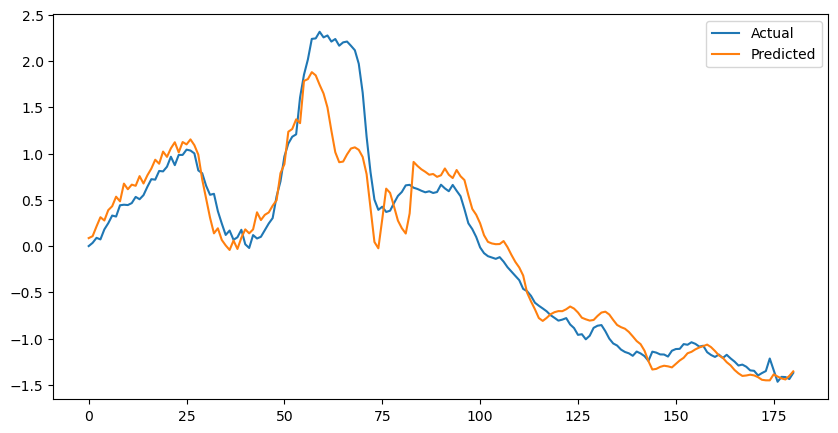

In [27]:
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_1)):
        pred = model123(test_tensor_seq_1[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

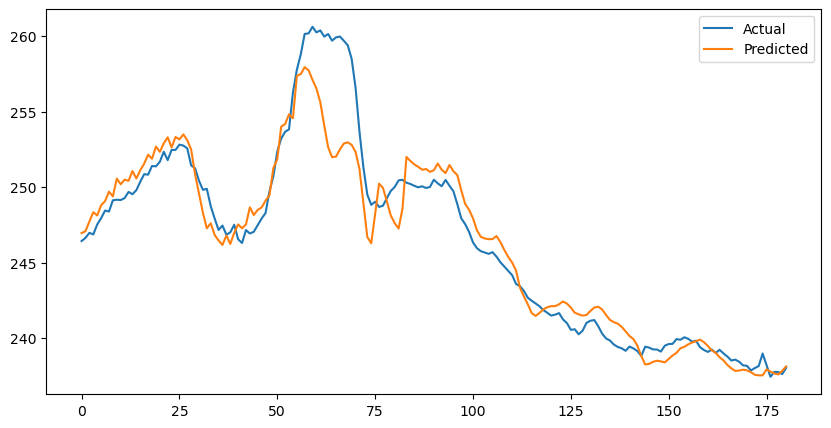

In [28]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * first_piece.std().values + first_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_1_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [29]:
print(f'MARE_np: {MARE_np(y_hat, test_labels_1_un)}')
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_1)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_1)}')
criterion123(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_1).item()

MARE_np: 0.005112154777026769
MARE: 1.3846851587295532
MSE: 0.09833109378814697


/home/raman-pc/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:1042: UserWarning: Using a target size (torch.Size([181, 1])) that is different to the input size (torch.Size([181])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


0.714873194694519

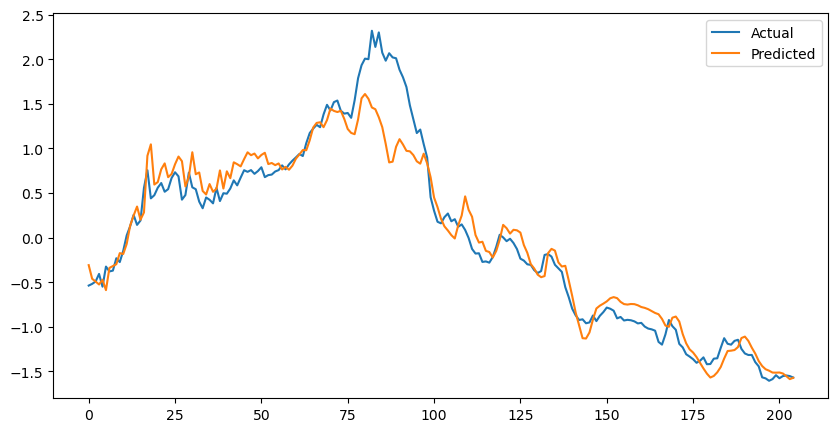

In [30]:
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_2)):
        pred = model123(test_tensor_seq_2[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

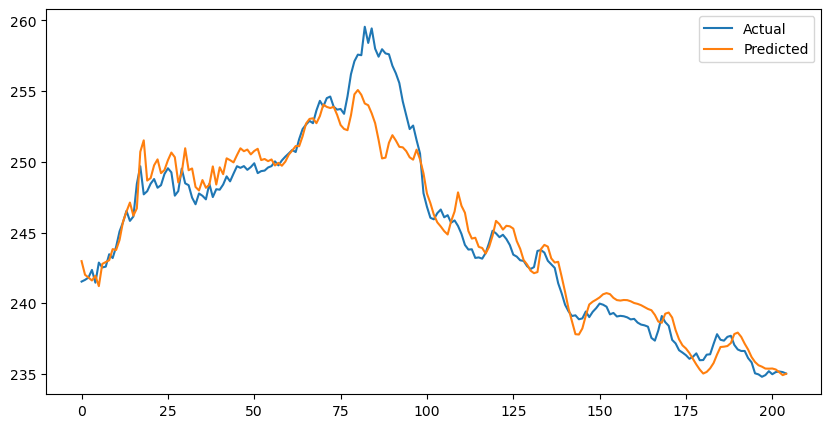

In [31]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * second_piece.std().values + second_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_2_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [32]:
print(f'MARE_np: {MARE_np(y_hat, test_labels_2_un)}')
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_2)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_2)}')
criterion123(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_2).item()

MARE_np: 0.0047050230890631145
MARE: 1.0376843214035034
MSE: 0.07602693885564804


/home/raman-pc/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:1042: UserWarning: Using a target size (torch.Size([205, 1])) that is different to the input size (torch.Size([205])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


0.7121409177780151

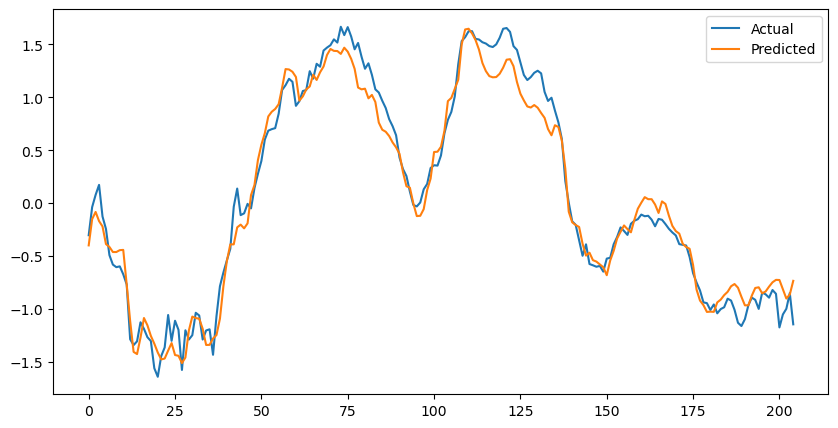

In [33]:
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_3)):
        pred = model123(test_tensor_seq_3[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

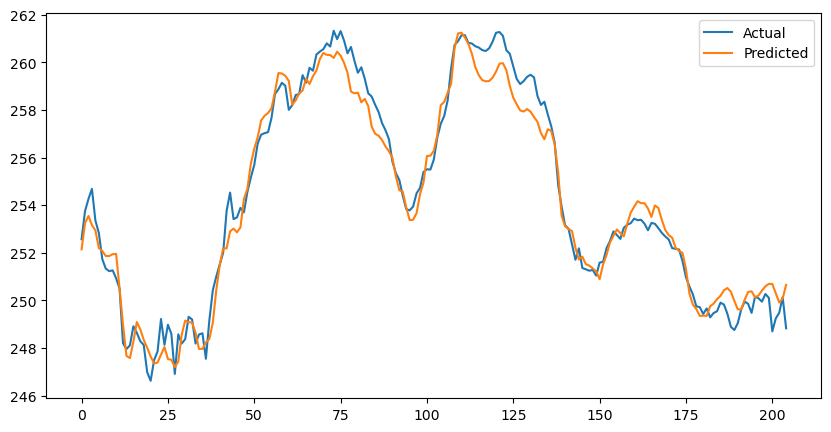

In [34]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * third_piece.std().values + third_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_3_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [35]:
print(f'MARE_np: {MARE_np(y_hat, test_labels_3_un)}')
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_3)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_3)}')
criterion123(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_3).item()

MARE_np: 0.0024188341715820783
MARE: 0.6653799414634705
MSE: 0.02957329712808132


0.6883614659309387

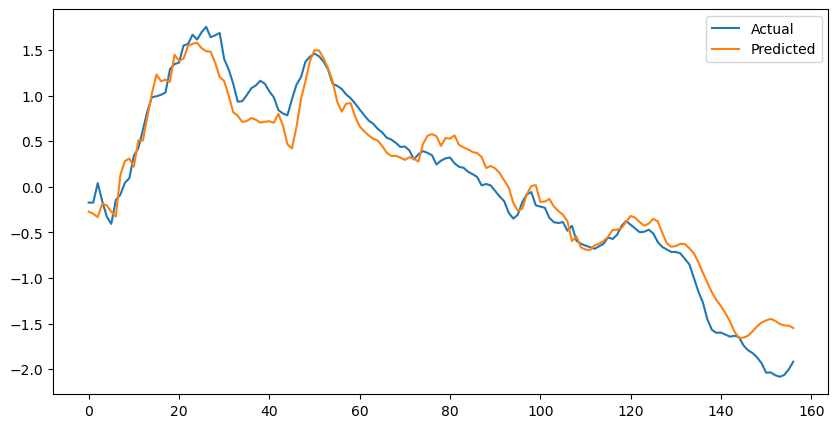

In [36]:
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_4)):
        pred = model123(test_tensor_seq_4[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

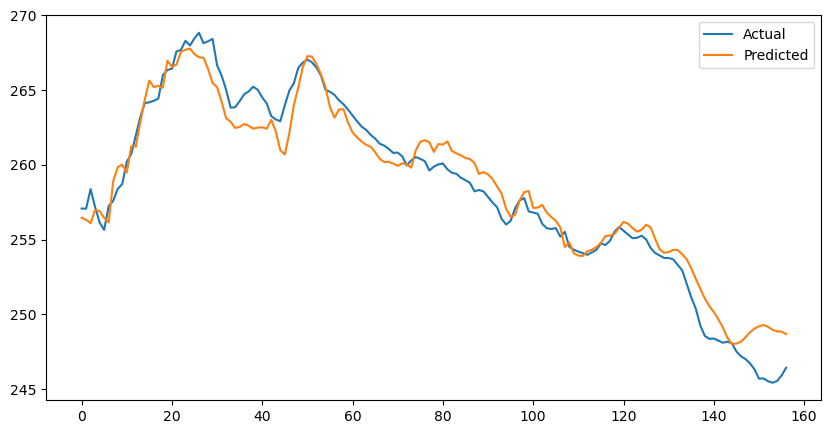

In [37]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * fourth_piece.std().values + fourth_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_4_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [38]:
print(f'MARE_np: {MARE_np(y_hat, test_labels_4_un)}')
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_4)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_4)}')
criterion123(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_4).item()

MARE_np: 0.004409885979389913
MARE: 0.7081153988838196
MSE: 0.053181760013103485


/home/raman-pc/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:1042: UserWarning: Using a target size (torch.Size([157, 1])) that is different to the input size (torch.Size([157])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


0.669721782207489

### Now let's train Model12 and test on 3 and 4

In [39]:
model12 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model12 = model12.to(device)  # Use "cuda" if you have a GPU

# model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
# model2 = model2.to("cuda")  # Use "cuda" if you have a GPU

# model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
# model3 = model3.to("cuda")  # Use "cuda" if you have a GPU

criterion12 = nn.SmoothL1Loss()
optimizer12 = optim.Adam(model12.parameters(), lr=1e-4)

In [40]:
num_epochs = 100
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor1)):
        model12.train()
    
        optimizer12.zero_grad()
        y_pred = model12(train_seq_tensor1[i])
        loss = criterion12(y_pred, train_label_tensor1[i])
        # print(loss.item())
        loss.backward()
        optimizer12.step()
    
        train_losses.append(loss.item())

    # Validation
    model12.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor1)):
                y_val = model12(val_seq_tensor1[i])
                val_loss = criterion12(y_val, val_label_tensor1[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.6683979034423828, Val Loss: 0.728935718536377
Epoch 10, Train Loss: 7.463683004971244e-07, Val Loss: 0.0036023471038788557
Epoch 20, Train Loss: 3.705382187035866e-05, Val Loss: 0.0023194528184831142
Epoch 30, Train Loss: 0.00380635354667902, Val Loss: 0.006050067022442818
Epoch 40, Train Loss: 0.00499621219933033, Val Loss: 0.005706082563847303
Epoch 50, Train Loss: 0.005103867035359144, Val Loss: 0.008428890258073807
Epoch 60, Train Loss: 0.004393044859170914, Val Loss: 0.006140463054180145
Epoch 70, Train Loss: 0.004294612444937229, Val Loss: 0.0028992341831326485
Epoch 80, Train Loss: 0.004120387136936188, Val Loss: 0.0008328638505190611
Epoch 90, Train Loss: 0.0008168663480319083, Val Loss: 0.0007835425203666091


In [41]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor2)):
        model12.train()
    
        optimizer12.zero_grad()
        y_pred = model12(train_seq_tensor2[i])
        loss = criterion12(y_pred, train_label_tensor2[i])
        # print(loss.item())
        loss.backward()
        optimizer12.step()
    
        train_losses.append(loss.item())

    # Validation
    model12.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor2)):
                y_val = model12(val_seq_tensor2[i])
                val_loss = criterion12(y_val, val_label_tensor2[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 3.390644633327611e-05, Val Loss: 0.00242439447902143
Epoch 10, Train Loss: 0.017773078754544258, Val Loss: 0.06875649094581604
Epoch 20, Train Loss: 3.5062734241364524e-05, Val Loss: 0.013684342615306377
Epoch 30, Train Loss: 0.0004155687347520143, Val Loss: 0.018593283370137215
Epoch 40, Train Loss: 3.911992462235503e-05, Val Loss: 0.0013669580221176147
Epoch 50, Train Loss: 0.0011112921638414264, Val Loss: 0.07994754612445831
Epoch 60, Train Loss: 0.0009283272083848715, Val Loss: 0.049303844571113586
Epoch 70, Train Loss: 3.510567125886155e-07, Val Loss: 0.014727921225130558
Epoch 80, Train Loss: 0.0006544753559865057, Val Loss: 0.07090054452419281
Epoch 90, Train Loss: 0.0006814313819631934, Val Loss: 0.10817716270685196


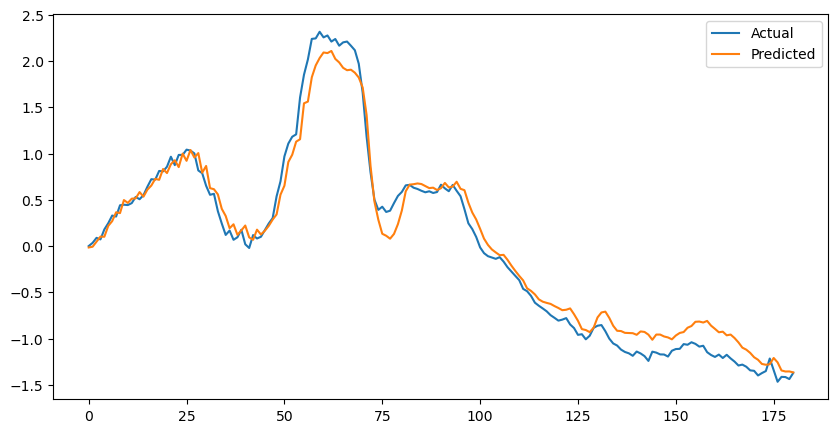

In [42]:
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_1)):
        pred = model12(test_tensor_seq_1[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

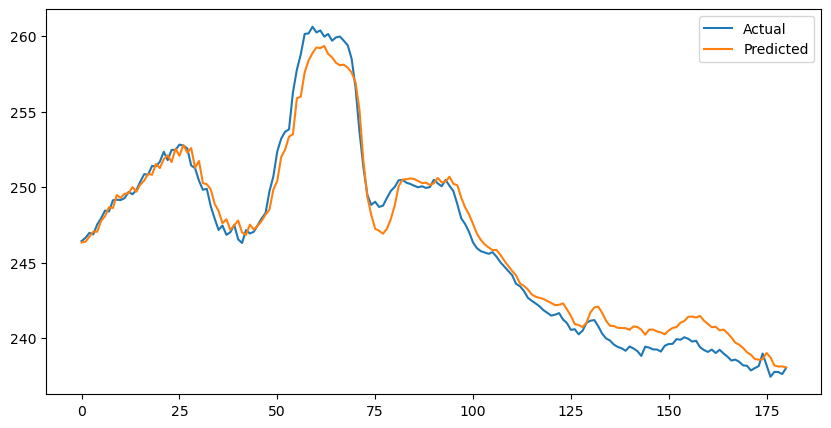

In [43]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * first_piece.std().values + first_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_1_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [44]:
print(f'MARE_np: {MARE_np(y_hat, test_labels_1_un)}')
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_1)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_1)}')
criterion123(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_1).item()

MARE_np: 0.003398609353957209
MARE: 0.5455366969108582
MSE: 0.02815781533718109


0.705126941204071

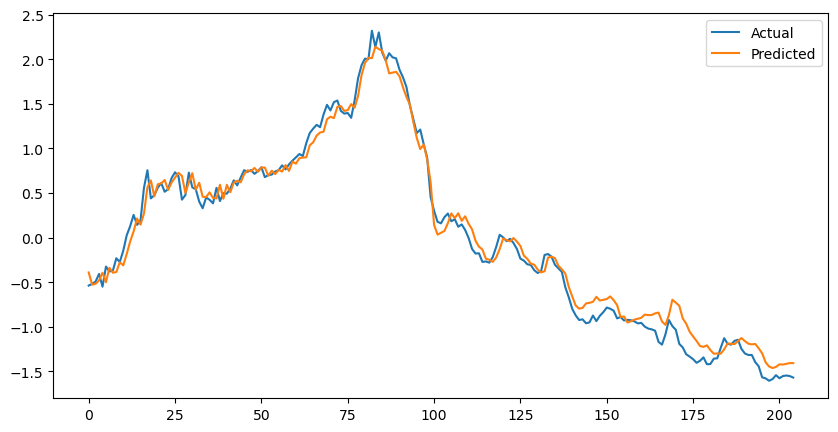

In [45]:
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_2)):
        pred = model12(test_tensor_seq_2[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

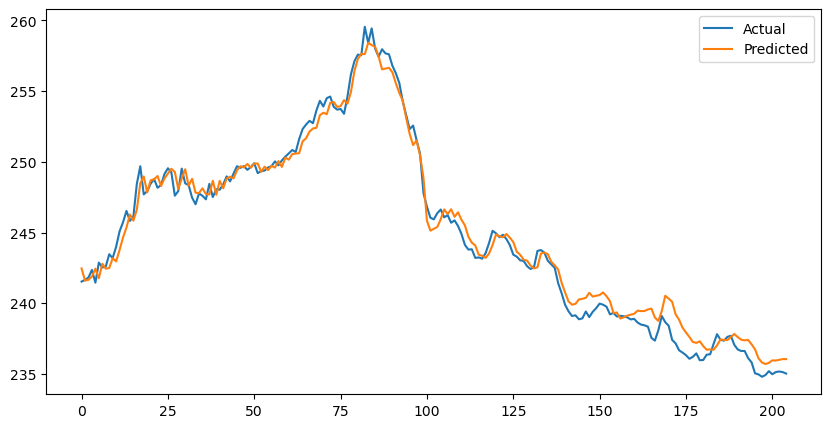

In [46]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * second_piece.std().values + second_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_2_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [47]:
print(f'MARE_np: {MARE_np(y_hat, test_labels_2_un)}')
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_2)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_2)}')
criterion123(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_2).item()

MARE_np: 0.0027983915815074155
MARE: 0.5054105520248413
MSE: 0.018527992069721222


0.7238970994949341

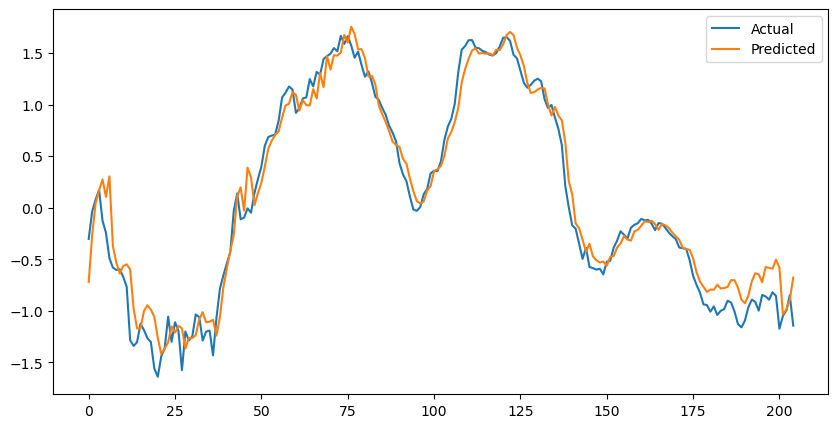

In [48]:
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_3)):
        pred = model12(test_tensor_seq_3[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

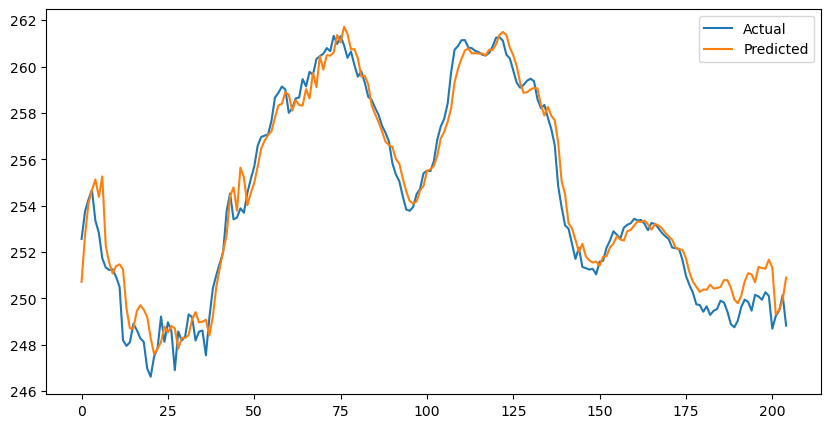

In [49]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * third_piece.std().values + third_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_3_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [50]:
print(f'MARE_np: {MARE_np(y_hat, test_labels_3_un)}')
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_3)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_3)}')
criterion123(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_3).item()

MARE_np: 0.002510648232893377
MARE: 1.008434534072876
MSE: 0.0370798334479332


0.6889655590057373

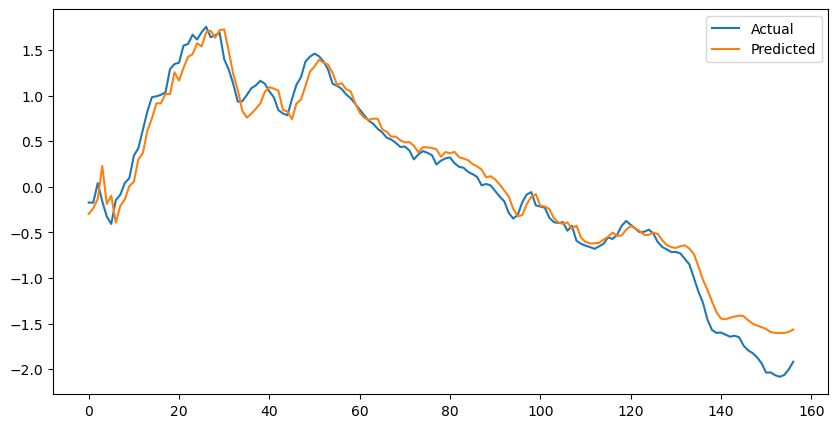

In [51]:
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_4)):
        pred = model12(test_tensor_seq_4[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

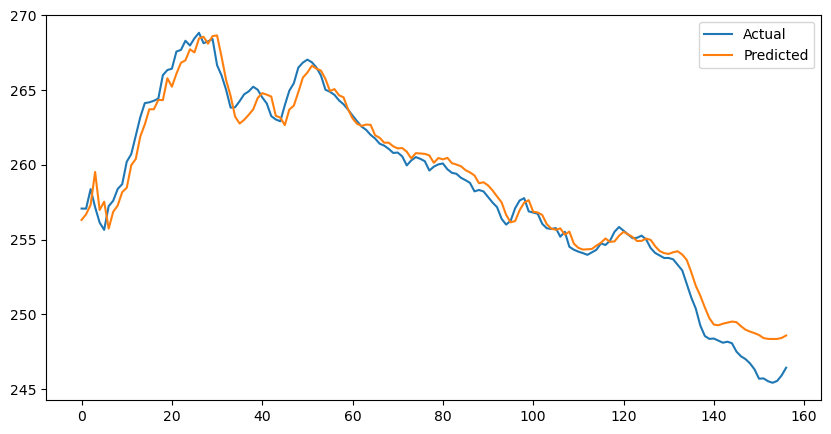

In [52]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * fourth_piece.std().values + fourth_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_4_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [53]:
print(f'MARE_np: {MARE_np(y_hat, test_labels_4_un)}')
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_4)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_4)}')
criterion123(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_4).item()

MARE_np: 0.003272213990916027
MARE: 0.43479418754577637
MSE: 0.03183315321803093


0.6906761527061462

### Let's also try Model124

In [54]:
model124 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model124 = model124.to(device)  # Use "cuda" if you have a GPU

# model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
# model2 = model2.to("cuda")  # Use "cuda" if you have a GPU

# model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
# model3 = model3.to("cuda")  # Use "cuda" if you have a GPU

criterion124 = nn.SmoothL1Loss()
optimizer124 = optim.Adam(model124.parameters(), lr=1e-4)

In [55]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor1)):
        model124.train()
    
        optimizer124.zero_grad()
        y_pred = model124(train_seq_tensor1[i])
        loss = criterion124(y_pred, train_label_tensor1[i])
        # print(loss.item())
        loss.backward()
        optimizer124.step()
    
        train_losses.append(loss.item())

    # Validation
    model124.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor1)):
                y_val = model124(val_seq_tensor1[i])
                val_loss = criterion124(y_val, val_label_tensor1[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.001984895672649145, Val Loss: 0.06579752266407013
Epoch 10, Train Loss: 3.7736295780632645e-05, Val Loss: 0.004134001210331917
Epoch 20, Train Loss: 1.5883460946497507e-05, Val Loss: 0.001629459671676159
Epoch 30, Train Loss: 0.003620309755206108, Val Loss: 0.006356825120747089
Epoch 40, Train Loss: 0.007601909805089235, Val Loss: 0.009322619065642357
Epoch 50, Train Loss: 0.006626162212342024, Val Loss: 0.006388316862285137
Epoch 60, Train Loss: 0.003974855877459049, Val Loss: 0.004124922677874565
Epoch 70, Train Loss: 0.0032043440733104944, Val Loss: 0.003320235526189208
Epoch 80, Train Loss: 0.0031948271207511425, Val Loss: 0.003248796798288822
Epoch 90, Train Loss: 0.0025435048155486584, Val Loss: 0.0011474486673250794


In [56]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor2)):
        model124.train()
    
        optimizer124.zero_grad()
        y_pred = model124(train_seq_tensor2[i])
        loss = criterion124(y_pred, train_label_tensor2[i])
        # print(loss.item())
        loss.backward()
        optimizer124.step()
    
        train_losses.append(loss.item())

    # Validation
    model124.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor2)):
                y_val = model124(val_seq_tensor2[i])
                val_loss = criterion124(y_val, val_label_tensor2[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.005465513560920954, Val Loss: 0.10030893981456757
Epoch 10, Train Loss: 0.005308324005454779, Val Loss: 0.03080124966800213
Epoch 20, Train Loss: 0.011030085384845734, Val Loss: 0.005183461122214794
Epoch 30, Train Loss: 0.0009584994404576719, Val Loss: 0.018781432881951332
Epoch 40, Train Loss: 0.001331703388132155, Val Loss: 0.09360542893409729
Epoch 50, Train Loss: 0.001046663150191307, Val Loss: 0.08470546454191208
Epoch 60, Train Loss: 0.00253876275382936, Val Loss: 0.14974619448184967
Epoch 70, Train Loss: 0.0002952155191451311, Val Loss: 0.0973099023103714
Epoch 80, Train Loss: 0.0011921045370399952, Val Loss: 0.18256166577339172
Epoch 90, Train Loss: 0.00031380014843307436, Val Loss: 0.07215017825365067


In [57]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(fourth_piece)
train_df4 =fourth_piece[0:int(n*0.8)]
val_df4 = fourth_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4
val_df4 = (val_df4 - train_mean4) / train_std4

# make sequences
train_seq4, train_labels4 = create_sequences(train_df4.values, 12)
val_seq4, val_labels4 = create_sequences(val_df4.values, 12)

# make tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4).to(device=device) # (batch, output_dim)
val_seq_tensor4 = torch.FloatTensor(val_seq4).to(device=device)  # (batch, seq_length, input_dim)
val_label_tensor4 = torch.FloatTensor(val_labels4).to(device=device)  # (batch, output_dim)

In [58]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor4)):
        model124.train()
    
        optimizer124.zero_grad()
        y_pred = model124(train_seq_tensor4[i])
        loss = criterion124(y_pred, train_label_tensor4[i])
        # print(loss.item())
        loss.backward()
        optimizer124.step()
    
        train_losses.append(loss.item())

    # Validation
    model124.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor4)):
                y_val = model124(val_seq_tensor4[i])
                val_loss = criterion124(y_val, val_label_tensor4[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.00013127707643434405, Val Loss: 0.19569116830825806
Epoch 10, Train Loss: 0.0023764059878885746, Val Loss: 0.34883254766464233
Epoch 20, Train Loss: 0.0010846740333363414, Val Loss: 0.4655689299106598
Epoch 30, Train Loss: 0.03160892054438591, Val Loss: 0.4778141379356384
Epoch 40, Train Loss: 0.008991655893623829, Val Loss: 0.32281047105789185
Epoch 50, Train Loss: 0.005482889246195555, Val Loss: 0.28716716170310974
Epoch 60, Train Loss: 0.0035554899368435144, Val Loss: 0.4845494031906128
Epoch 70, Train Loss: 0.004856106359511614, Val Loss: 0.587868332862854
Epoch 80, Train Loss: 0.004027386195957661, Val Loss: 0.43661412596702576
Epoch 90, Train Loss: 0.0071715256199240685, Val Loss: 0.4625427722930908


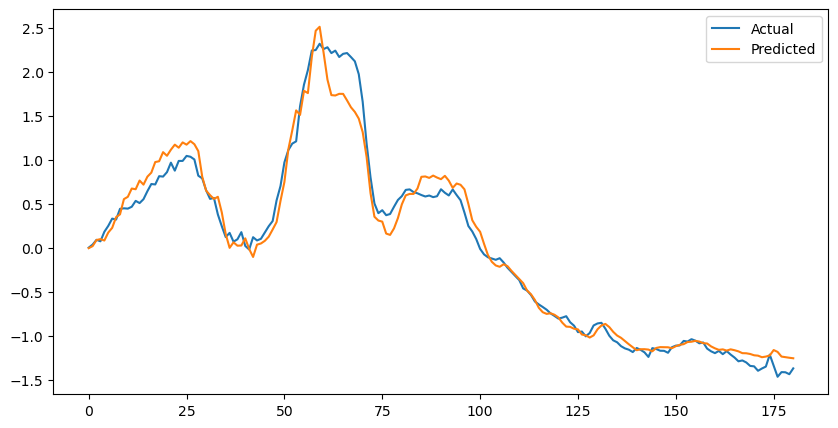

In [59]:
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_1)):
        pred = model124(test_tensor_seq_1[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

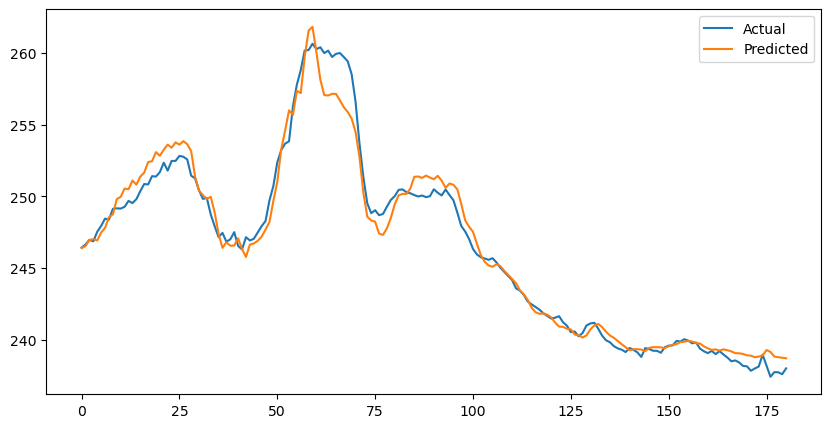

In [60]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * first_piece.std().values + first_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_1_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [61]:
print(f'MARE_np: {MARE_np(y_hat, test_labels_1_un)}')
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_1)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_1)}')
criterion123(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_1).item()

MARE_np: 0.0030095890927518123
MARE: 0.368937224149704
MSE: 0.028850102797150612


0.7424591779708862

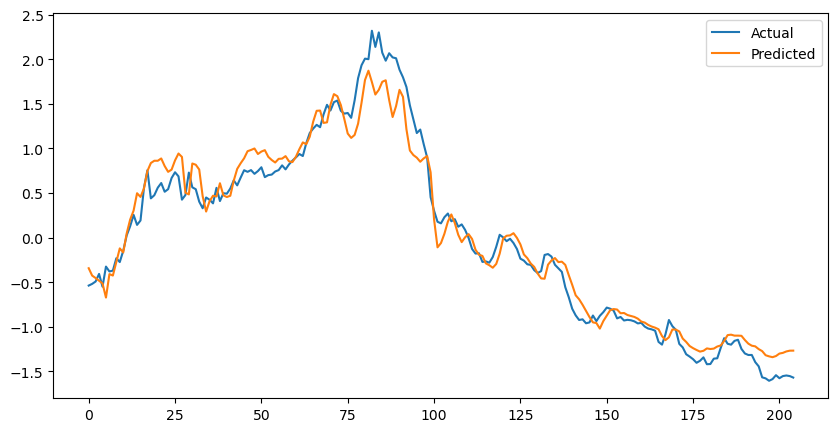

In [62]:
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_2)):
        pred = model124(test_tensor_seq_2[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

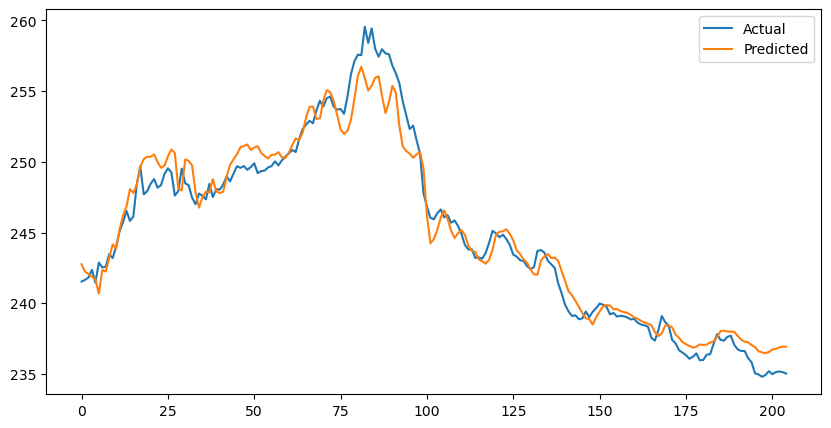

In [63]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * second_piece.std().values + second_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_2_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [64]:
print(f'MARE_np: {MARE_np(y_hat, test_labels_2_un)}')
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_2)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_2)}')
criterion123(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_2).item()

MARE_np: 0.0040120059836175545
MARE: 0.4065718352794647
MSE: 0.042106423527002335


0.7224986553192139

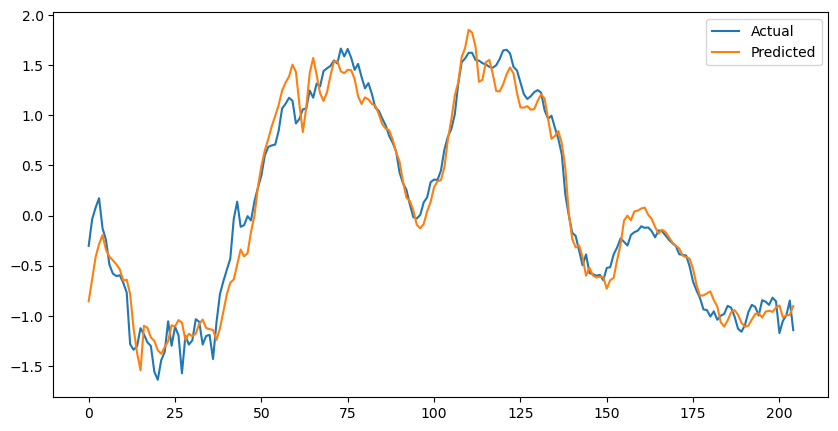

In [65]:
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_3)):
        pred = model124(test_tensor_seq_3[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

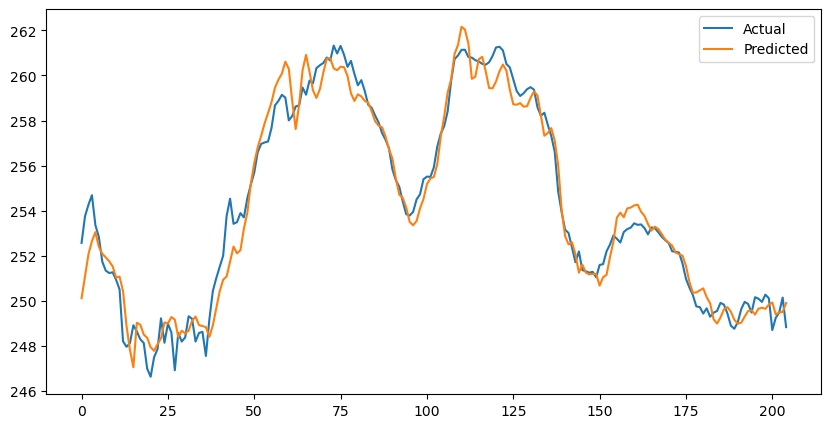

In [66]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * third_piece.std().values + third_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_3_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [67]:
print(f'MARE_np: {MARE_np(y_hat, test_labels_3_un)}')
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_3)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_3)}')
criterion123(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_3).item()

MARE_np: 0.00257810700842175
MARE: 0.9516653418540955
MSE: 0.037319812923669815


0.7133574485778809

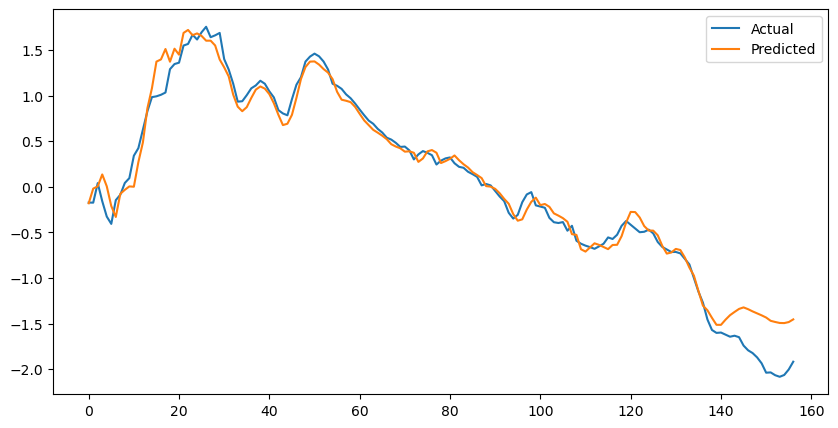

In [68]:
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_4)):
        pred = model124(test_tensor_seq_4[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

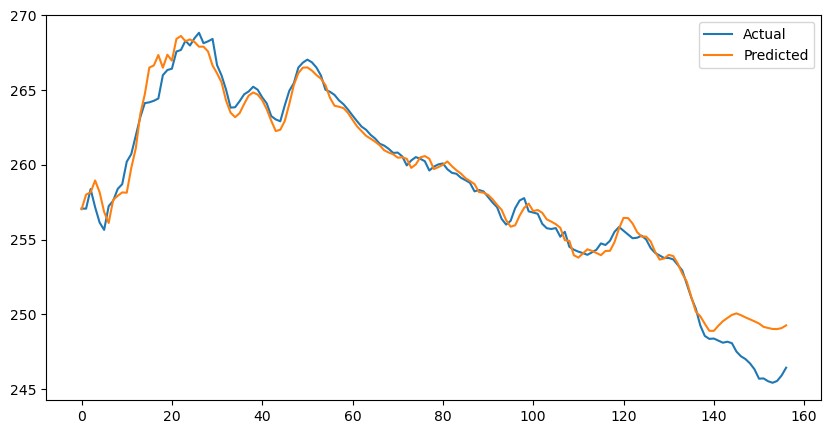

In [69]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * fourth_piece.std().values + fourth_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_4_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [70]:
print(f'MARE_np: {MARE_np(y_hat, test_labels_4_un)}')
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_4)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_4)}')
criterion123(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_4).item()

MARE_np: 0.0029178888107341846
MARE: 0.2637597322463989
MSE: 0.0344320572912693


0.6970423460006714